# Exercise Generation script from the Tatoeba database

In [1]:
import pandas as pd
from tqdm import tqdm
import missingno as msno

import spacy

import pickle

nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")

The Data comes from Tatoeba and is the list in tsv format of the sentences in the target language and their traduction in the source language. The data is available here: https://tatoeba.org/eng/downloads

In [2]:
english_words = pd.read_csv("Data/english_corpus.tsv", sep="\t")["English Word"].astype(str).to_list()

tatoebaJapDf = pd.read_csv("Data/tatoeba - English-Japanese - 2022-10-14.tsv", sep="\t", header=None)
tatoebaJapDf.columns = ["English ID", "English sentence", "Japanese ID", "Japanese sentence"]

tatoebaPorDf = pd.read_csv("Data/tatoeba - English-Portuguese - 2022-10-14.tsv", sep="\t", header=None, on_bad_lines="skip")
tatoebaPorDf.columns = ["English ID", "English sentence", "Portuguese ID", "Portuguese sentence"]

print(len(english_words))


6003


We filter out any of the words that do not make sense

In [3]:
english_words_filtered = [word for word in english_words if (" " not in word) and ("(" not in word) and ("?" not in word)]
print(len(english_words_filtered))
english_words_filtered.sort()

lemmatized_english_words = [nlp_en(word)[0].lemma_ for word in tqdm(english_words_filtered)]
print(len(lemmatized_english_words))
lemmatized_english_words

4450


100%|██████████| 4450/4450 [00:15<00:00, 291.45it/s]

4450


['AIDS',
 'Abandon',
 'abandon',
 'abbreviation',
 'abdoman',
 'ability',
 'ablution',
 'about',
 'about',
 'above',
 'abrupt',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorption',
 'abstention',
 'abstract',
 'absurd',
 'absurd',
 'absurd',
 'abuse',
 'academic',
 'academy',
 'acceleration',
 'accent',
 'accident',
 'Accidental',
 'accomplice',
 'accord',
 'accordion',
 'accountant',
 'accounting',
 'accurate',
 'accuse',
 'accustomed',
 'achievable',
 'acid',
 'acidity',
 'acne',
 'Acrobat',
 'across',
 'action',
 'active',
 'activist',
 'activity',
 'actor',
 'actress',
 'acupuncture',
 'add',
 'addict',
 'addiction',
 'address',
 'adjective',
 'administration',
 'administration',
 'administrative',
 'admire',
 'adolescence',
 'adolescence',
 'adorable',
 'adult',
 'advantage',
 'advantageous',
 'Adverb',
 'advertising',
 'advice',
 'aerodrome',
 'aerodrome',
 'aerosol',
 'aerospace',
 'aerospatial',
 'affect',
 'affectionately',
 'afghan',
 'Afghanistan',
 

Lemmatization of the words in the sentences of tatoeba to be able to match them.
This can take 15mins so we save the result in a file

In [21]:
list_of_lemma_in_english_sentences = []
for sentence in tqdm(tatoebaPorDf["English sentence"]):
    list_of_lemma_in_english_sentences.append([x.lemma_ for x in nlp_en(sentence)])
pickle.dump(list_of_lemma_in_english_sentences, open("Data/list_of_lemma_in_english_sentences.pkl", "wb"))


100%|██████████| 268460/268460 [17:18<00:00, 258.44it/s]


In [60]:
english_target_sentences = []

lower_list_of_lemma_in_english_sentences = [[word.lower() for word in sentence] for sentence in list_of_lemma_in_english_sentences]

for english_word in tqdm(english_words_filtered):
    lemma = nlp_en(english_word)[0].lemma_
    lemma_lower = lemma.lower()

    # This is the most important line that finds the sentences that contain the word.
    # It only works because the lemmatized sentences are in the same order and have the same index as the original sentences.
    sentencesContainingEnWord = [{"source": tatoebaPorDf.loc[tatoebaPorDf.index[idx], "English sentence"], "target": tatoebaPorDf.loc[tatoebaPorDf.index[idx], "Portuguese sentence"]} for idx, sentence in enumerate(lower_list_of_lemma_in_english_sentences) if lemma_lower in sentence]

    if len(sentencesContainingEnWord) > 0:
        sentencesContainingEnWord.sort(key=lambda s: len(s["source"]))
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": sentencesContainingEnWord[0]["source"],
            "Long English Sentence": sentencesContainingEnWord[-1]["source"],
            "Short Target Sentence": sentencesContainingEnWord[0]["target"],
            "Long Target Sentence": sentencesContainingEnWord[-1]["target"],
        })
    else :
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": pd.NA,
            "Long English Sentence": pd.NA,
            "Short Target Sentence": pd.NA,
            "Long Target Sentence": pd.NA,
        })

result = pd.DataFrame(english_target_sentences)
result.to_csv("Data/english_portuguese_corpus.tsv", sep="\t", index=False)
result

100%|██████████| 4450/4450 [04:28<00:00, 16.58it/s]


,English Word,English Lemma,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AIDS,Scientists are working hard to put an end to A...,U.S. Secretary of State Hillary Clinton has ma...,Cientistas estão trabalhando duro para acabar ...,A secretária de Estado norte-americana Hillary...
1,Abandon,Abandon,Abandon ship!,"As a result, some countries that have tight pa...",Abandonar o navio!,"Como resultado, alguns países que têm restriçõ..."
2,Abandoned,abandon,Abandon ship!,"As a result, some countries that have tight pa...",Abandonar o navio!,"Como resultado, alguns países que têm restriçõ..."
3,Abbreviation,abbreviation,Apr. is an abbreviation for April.,"The abbreviation of ""Chinese People's Politica...",Abr. é a abreviação para abril.,"A abreviação para ""Conferência Consultiva Polí..."
4,Abdomen,abdoman,He hit him in the abdomen.,"The body of an insect is divided into head, th...",Ele o socou na altura do abdômen.,Os insetos apresentam o corpo divido em cabeça...
...,...,...,...,...,...,...
4445,nan,nan,"Grinning, Tom gave Grandad the cue for one of ...","Grinning, Tom gave Grandad the cue for one of ...","Sorridente, o Tom deu ao Bu a deixa para ele c...","Sorridente, o Tom deu ao Bu a deixa para ele c..."
4446,nan,nan,"Grinning, Tom gave Grandad the cue for one of ...","Grinning, Tom gave Grandad the cue for one of ...","Sorridente, o Tom deu ao Bu a deixa para ele c...","Sorridente, o Tom deu ao Bu a deixa para ele c..."
4447,wrong,wrong,Wrong.,"“Now, it is very remarkable that this is so ex...",Errado.,"Agora, é muito notável que isto seja tão ampla..."
4448,wrong,wrong,Wrong.,"“Now, it is very remarkable that this is so ex...",Errado.,"Agora, é muito notável que isto seja tão ampla..."


## Assessing the quality of the results

In [4]:
english_portuguese_corpus = pd.read_csv("Data/english_portuguese_corpus.tsv", sep="\t")
english_portuguese_corpus

,English Word,English Lemma,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AIDS,Scientists are working hard to put an end to A...,U.S. Secretary of State Hillary Clinton has ma...,Cientistas estão trabalhando duro para acabar ...,A secretária de Estado norte-americana Hillary...
1,Abandon,Abandon,Abandon ship!,"As a result, some countries that have tight pa...",Abandonar o navio!,"Como resultado, alguns países que têm restriçõ..."
2,Abandoned,abandon,Abandon ship!,"As a result, some countries that have tight pa...",Abandonar o navio!,"Como resultado, alguns países que têm restriçõ..."
3,Abbreviation,abbreviation,Apr. is an abbreviation for April.,"The abbreviation of ""Chinese People's Politica...",Abr. é a abreviação para abril.,"A abreviação para ""Conferência Consultiva Polí..."
4,Abdomen,abdoman,He hit him in the abdomen.,"The body of an insect is divided into head, th...",Ele o socou na altura do abdômen.,Os insetos apresentam o corpo divido em cabeça...
...,...,...,...,...,...,...
4445,NaN,NaN,"Grinning, Tom gave Grandad the cue for one of ...","Grinning, Tom gave Grandad the cue for one of ...","Sorridente, o Tom deu ao Bu a deixa para ele c...","Sorridente, o Tom deu ao Bu a deixa para ele c..."
4446,NaN,NaN,"Grinning, Tom gave Grandad the cue for one of ...","Grinning, Tom gave Grandad the cue for one of ...","Sorridente, o Tom deu ao Bu a deixa para ele c...","Sorridente, o Tom deu ao Bu a deixa para ele c..."
4447,wrong,wrong,Wrong.,"“Now, it is very remarkable that this is so ex...",Errado.,"Agora, é muito notável que isto seja tão ampla..."
4448,wrong,wrong,Wrong.,"“Now, it is very remarkable that this is so ex...",Errado.,"Agora, é muito notável que isto seja tão ampla..."


<AxesSubplot:>

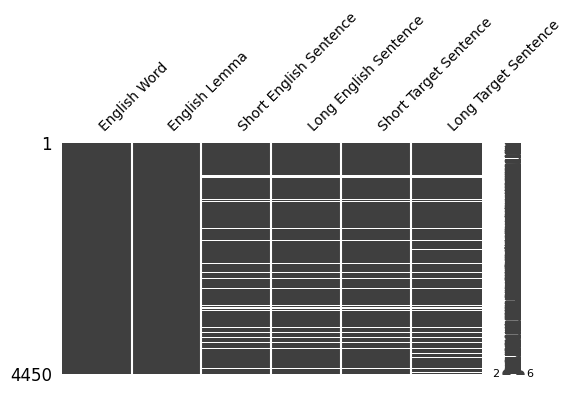

In [61]:
msno.matrix(english_portuguese_corpus, figsize=(6, 3), fontsize=10)

In [66]:
print(english_portuguese_corpus.count())

counter = 0
for idx, row in english_portuguese_corpus.iterrows():
    if row["Short English Sentence"] is row["Long English Sentence"] and type(row["Short English Sentence"]) is str:
        print(row["English Word"], row["English Lemma"], row["Short English Sentence"], row["Short Target Sentence"])
        counter += 1
print("Number of words with only one sentence:", counter)


English Word              4446
English Lemma             4446
Short English Sentence    4074
Long English Sentence     4074
Short Target Sentence     4074
Long Target Sentence      4053
dtype: int64
Number of words with only one sentence: 0


## Getting the translation for the target words

In [5]:
from googletrans import Translator # Library only works in alpha: pip install googletrans==3.1.0a0
translator = Translator()

In [ ]:
translated_lemmatized_english_words = [translator.translate(word, src="en", dest="pt").text for word in tqdm(lemmatized_english_words)]
translated_lemmatized_english_words